In [47]:
import os
import json
import copy
import typing

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import scipy
import scipy.signal
import scipy.stats

from utils.image_processing import *


with open("./images/tasks.json", "r") as task_imglist_file:
    TASK_IMGLIST = json.load(task_imglist_file)
    
IMAGES = {}
for task in TASK_IMGLIST:
    for img_name in TASK_IMGLIST[task]:
        IMAGES[img_name] = cv.imread('./images/' + img_name, cv.IMREAD_GRAYSCALE)
        
BINARIZED_IMAGES = {}
CONNECTED_COMPONENTS = {}

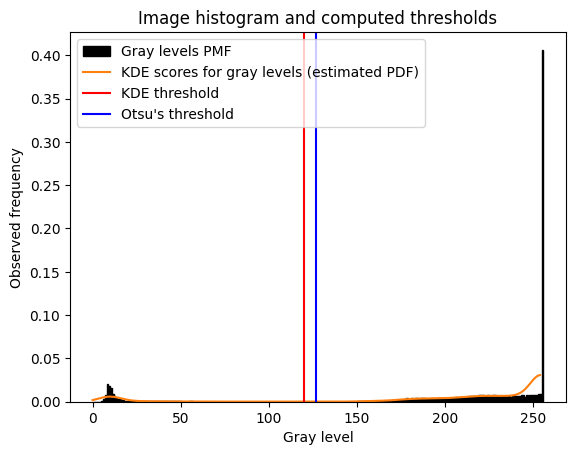

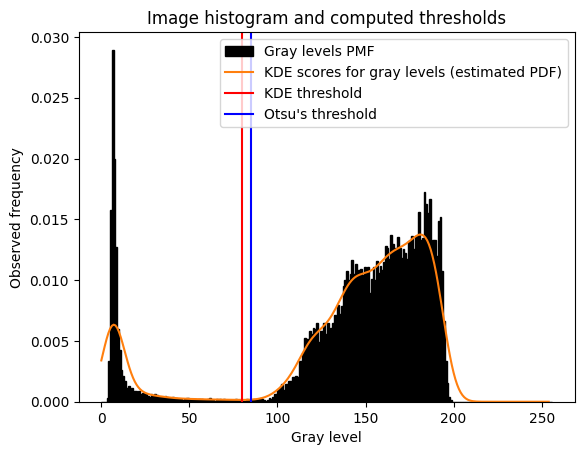

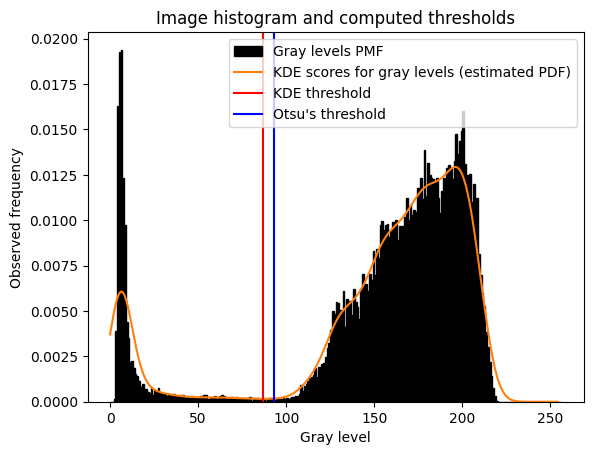

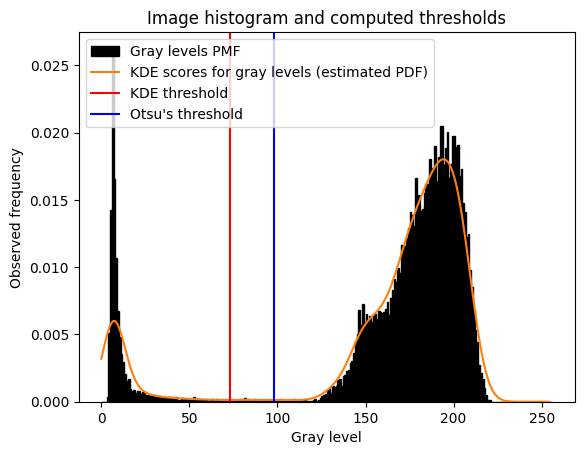

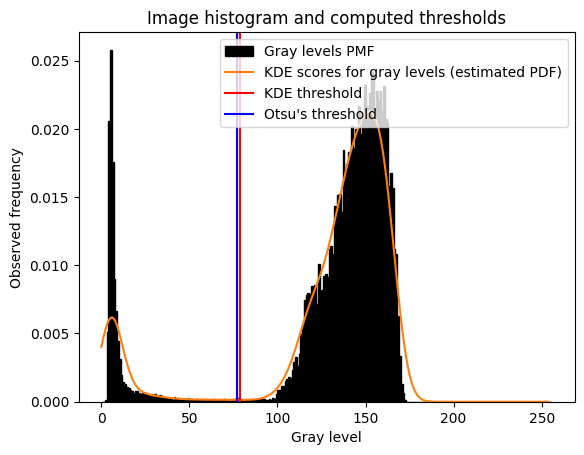

In [48]:
for img_name in TASK_IMGLIST['TASK_1']:
    X = np.arange(255)[:, None]
    kde = KernelDensity(kernel='gaussian', bandwidth=6).fit(IMAGES[img_name].ravel()[:, None])
    log_dens = kde.score_samples(X)
    threshold = scipy.signal.argrelmin(log_dens)[0][0]
    otsu_threshold, _ = cv.threshold(IMAGES[img_name], 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    plt.hist(IMAGES[img_name].ravel(), bins=256, range=(0, 256), density=True, fc='k', ec='k', label='Gray levels PMF') #calculating histogram
    plt.plot(np.exp(log_dens), label='KDE scores for gray levels (estimated PDF)')
    plt.axvline(x=threshold, color='red', label='KDE threshold')
    plt.axvline(x=otsu_threshold, color='blue', label='Otsu\'s threshold')
    plt.xlabel('Gray level')
    plt.ylabel('Observed frequency')
    plt.title('Image histogram and computed thresholds')
    plt.legend()
    plt.show()

## FIRST TASK ##

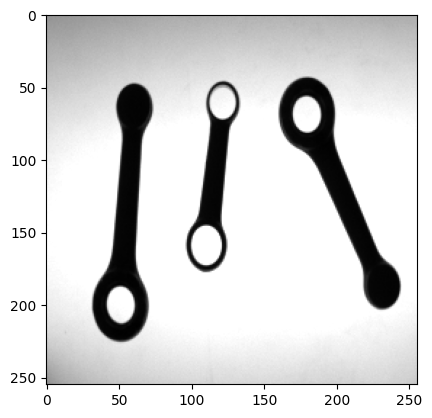

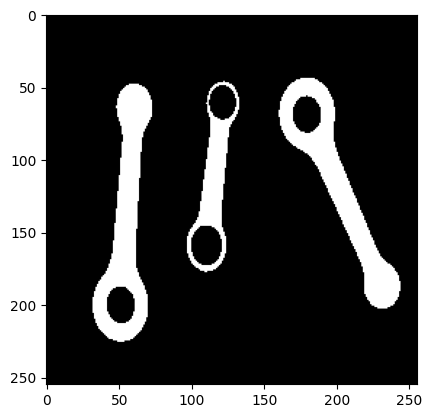

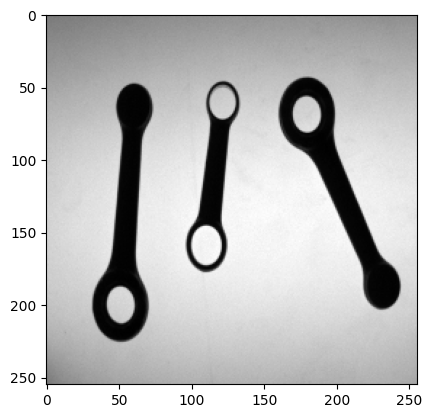

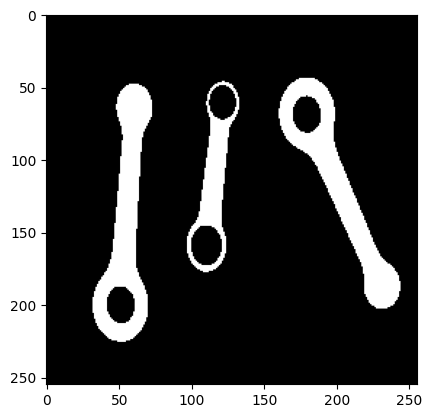

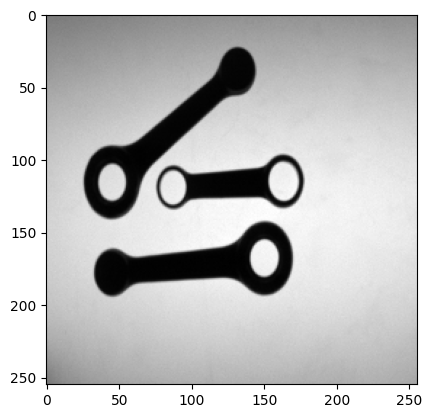

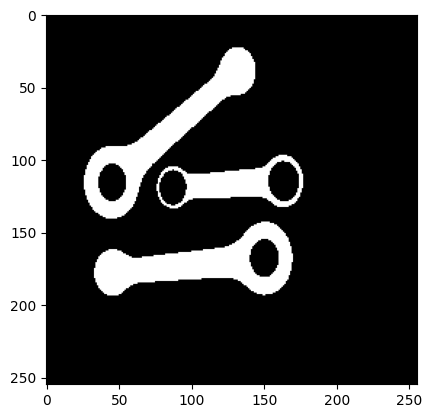

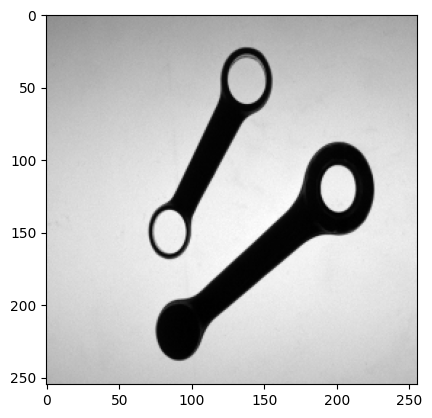

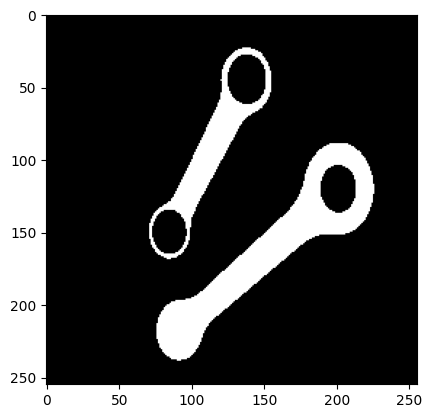

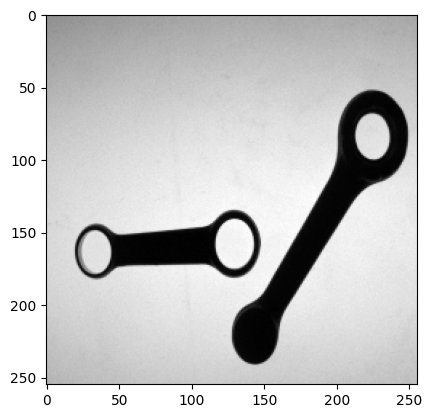

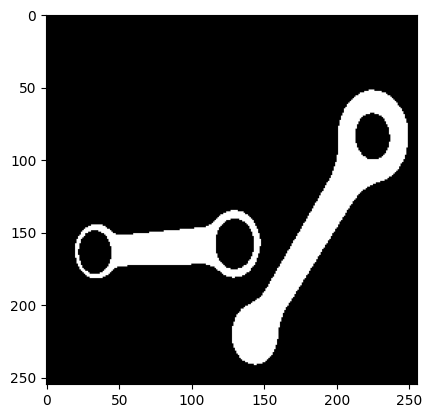

In [49]:
for img_name in TASK_IMGLIST['TASK_1']:
    threshold, binarized_img = binarizeImage(IMAGES[img_name], kde_bandwidth=6)
    BINARIZED_IMAGES[img_name] = binarized_img
    plt.imshow(IMAGES[img_name], cmap="gray")
    plt.show()
    plt.imshow(binarized_img, cmap="gray")
    plt.show()

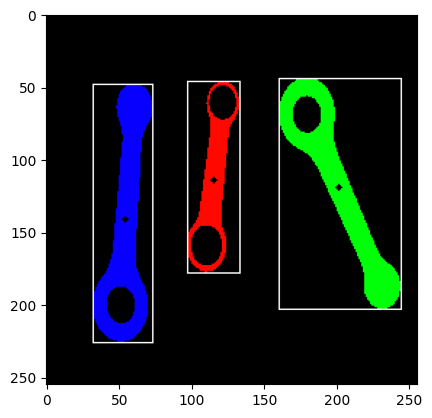

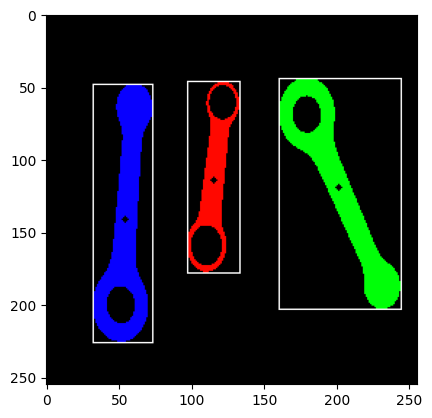

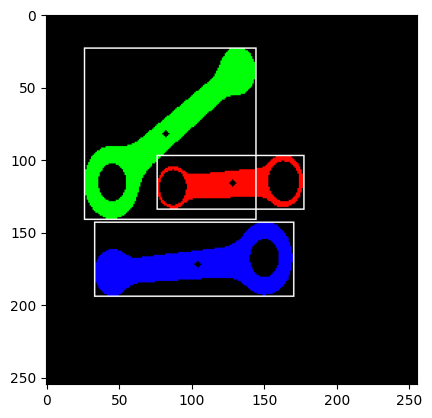

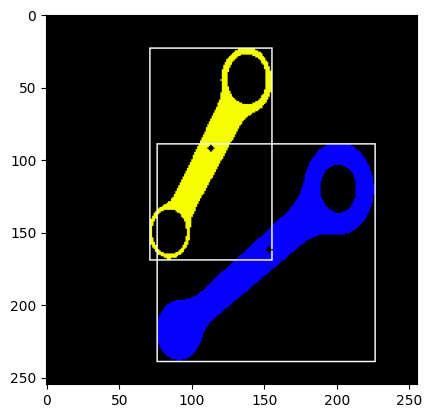

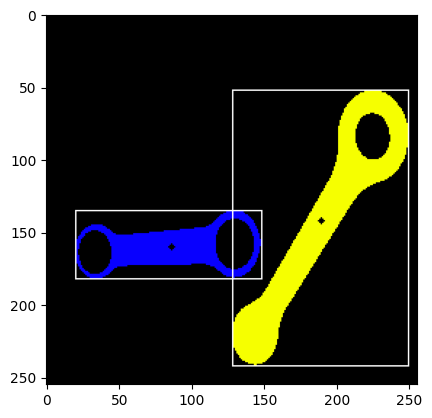

In [50]:
for img_name in TASK_IMGLIST['TASK_1']:
    n_labels, label_ids, stats, centroids = cv.connectedComponentsWithStats(BINARIZED_IMAGES[img_name], connectivity=4)
    CONNECTED_COMPONENTS[img_name] = (n_labels, label_ids, stats, centroids)
    plot_connected_components(n_labels, label_ids, stats, centroids)

In [51]:
def getCCMask(labels, label):
    mask = np.zeros_like(labels, dtype=np.uint8)
    mask[labels == label] = 255
    return mask

def getMoment(mask: np.ndarray, order: typing.Tuple[int,int], barycenter: typing.Tuple[int, int] = (0,0)) -> int:
    i, j = np.where(mask)
    return np.sum(((i - barycenter[0]) ** order[0]) * ((j - barycenter[1]) ** order[1]))

def getAngleAndAxes(mask: np.ndarray, blob_area: int):
    i_b, j_b = (getMoment(mask, (1,0)), getMoment(mask, (0,1))) / blob_area
    m_0_2 = getMoment(mask, (0,2), barycenter=(i_b,j_b))
    m_2_0 = getMoment(mask, (2,0), barycenter=(i_b,j_b))
    m_1_1 = getMoment(mask, (1,1), barycenter=(i_b,j_b))
    
    theta = -0.5 * np.arctan(2 * m_1_1 / (m_0_2 - m_2_0)) + np.pi / 2
    second_derivative = 2 * (m_0_2 - m_2_0) * np.cos(2 * theta) - 4 * m_1_1 * np.sin(2 * theta)
    if second_derivative < 0:
        theta -= np.pi / 2
        
    alpha = -np.sin(theta)
    beta = np.cos(theta)
    
    a = alpha
    b = -beta
    c = beta * i_b - alpha * j_b
    
    a_prime = beta
    b_prime = alpha
    c_prime = -beta * j_b - alpha * i_b
    
    return (theta, (a, b, c), (a_prime, b_prime, c_prime))

def findMER(major_axis: typing.Tuple[float,float,float], minor_axis: typing.Tuple[float,float,float], edges: np.ndarray):
    dMAmin = np.inf
    dMImin = np.inf
    dMAmax = -np.inf
    dMImax = -np.inf
    normMA = np.sqrt(major_axis[0] * major_axis[0] + major_axis[1] * major_axis[1])
    normMI = np.sqrt(minor_axis[0] * minor_axis[0] + minor_axis[1] * minor_axis[1])
    C1 = np.zeros((2,), dtype=np.int32)
    C2 = np.zeros((2,), dtype=np.int32)
    C3 = np.zeros((2,), dtype=np.int32)
    C4 = np.zeros((2,), dtype=np.int32)
    V1 = np.zeros((2,), dtype=np.int32)
    V2 = np.zeros((2,), dtype=np.int32)
    V3 = np.zeros((2,), dtype=np.int32)
    V4 = np.zeros((2,), dtype=np.int32)
    
    for i in range(edges.shape[0]):
        dMA = (major_axis[0] * edges[i][0][0] + major_axis[1] * edges[i][0][1] + major_axis[2]) /  normMA
        dMI = (minor_axis[0] * edges[i][0][0] + minor_axis[1] * edges[i][0][1] + minor_axis[2]) /  normMI
        if dMA < dMAmin:
            dMAmin = dMA
            C1[0] = edges[i][0][0]
            C1[1] = edges[i][0][1]
        elif dMA > dMAmax:
            dMAmax = dMA
            C2[0] = edges[i][0][0]
            C2[1] = edges[i][0][1]
        if dMI < dMImin:
            dMImin = dMI
            C3[0] = edges[i][0][0]
            C3[1] = edges[i][0][1]
        elif dMI > dMImax:
            dMImax = dMI
            C4[0] = edges[i][0][0]
            C4[1] = edges[i][0][1]
    
    c_l_1 = -(major_axis[0] * C1[0] + major_axis[1] * C1[1])
    c_l_2 = -(major_axis[0] * C2[0] + major_axis[1] * C2[1])
    c_w_1 = -(minor_axis[0] * C3[0] + minor_axis[1] * C3[1])
    c_w_2 = -(minor_axis[0] * C4[0] + minor_axis[1] * C4[1])
    
    V1[0] = np.ceil((major_axis[1] * c_w_1 - minor_axis[1] * c_l_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V2[0] = np.ceil((major_axis[1] * c_w_2 - minor_axis[1] * c_l_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V3[0] = np.ceil((major_axis[1] * c_w_1 - minor_axis[1] * c_l_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V4[0] = np.ceil((major_axis[1] * c_w_2 - minor_axis[1] * c_l_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    
    V1[1] = np.ceil((minor_axis[0] * c_l_1 - major_axis[0] * c_w_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V2[1] = np.ceil((minor_axis[0] * c_l_1 - major_axis[0] * c_w_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V3[1] = np.ceil((minor_axis[0] * c_l_2 - major_axis[0] * c_w_1) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    V4[1] = np.ceil((minor_axis[0] * c_l_2 - major_axis[0] * c_w_2) / (major_axis[0] * minor_axis[1] - major_axis[1] * minor_axis[0]))
    
    return V1, V2, V3, V4, C1, C2, C3, C4

def getWidthAtBarycenter(edges: np.ndarray, minor_axis: typing.Tuple[float, float, float], major_axis: typing.Tuple[float, float, float]):
    points_placement_wrt_major_axis = edges[:,:,0] * major_axis[0] + edges[:,:,1] * major_axis[1] + major_axis[2]
    contour_points_distance_from_minor_axis = np.abs(edges[:,:,0] * minor_axis[0] + edges[:,:,1] * minor_axis[1] + minor_axis[2]) / np.sqrt(minor_axis[0] ** 2 + minor_axis[1] ** 2)
    left_indexes = np.where(points_placement_wrt_major_axis < 0)[0]
    right_indexes = np.where(points_placement_wrt_major_axis >= 0)[0]
    left_extreme = edges[left_indexes[np.argmin(contour_points_distance_from_minor_axis[left_indexes])]]
    right_extreme = edges[right_indexes[np.argmin(contour_points_distance_from_minor_axis[right_indexes])]]
    
    return np.linalg.norm(left_extreme - right_extreme), left_extreme, right_extreme

def getHoleCenterAndDiameter(hole_contour: np.ndarray):
    center, _, _ = cv.fitEllipse(hole_contour)
    area = cv.contourArea(hole_contour)
    radius = np.sqrt(area / np.pi)
    
    return center, 2 * radius

def computeHaralickCircularity(edges: np.array, barycenter: typing.Tuple[float, float]):
    distances = np.sqrt(np.sum((edges - np.flip(np.array(barycenter))) ** 2, axis=2))
    mu_r = np.mean(distances)
    sigma_r = np.sqrt(np.mean((distances - mu_r) ** 2))
    return mu_r / sigma_r

The rod labeled 1 in the image TESI00.BMP is of type A
Its barycenter is at position [119.10483871 201.37531017], it has an orientation angle of 113.21 degrees, its length is 168.47, its width is 39.92, and its width at the barycenter is 15.23
The only hole in the rod is at position (179.02664184570312, 68.68199157714844) and has diameter equal to 23.15


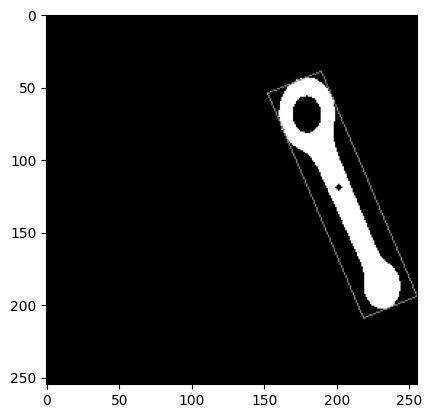

The rod labeled 2 in the image TESI00.BMP is of type B
Its barycenter is at position [114.29904632 115.21117166], it has an orientation angle of 83.40 degrees, its length is 130.86, its width is 27.17, and its width at the barycenter is 14.04
The first hole in the rod is at position (109.97039031982422, 158.95977783203125) and has diameter equal to 25.23
The second hole in the rod is at position (121.0817642211914, 60.385562896728516) and has diameter equal to 21.88


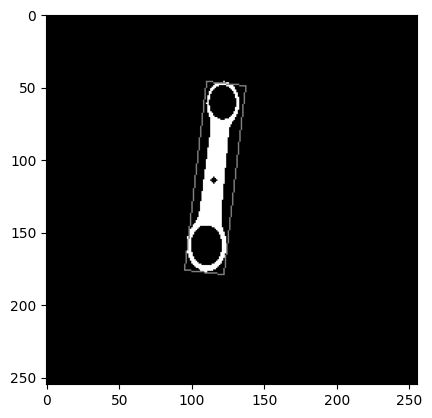

The rod labeled 3 in the image TESI00.BMP is of type A
Its barycenter is at position [141.32237246  54.83159189], it has an orientation angle of 85.97 degrees, its length is 177.48, its width is 38.12, and its width at the barycenter is 14.04
The only hole in the rod is at position (51.002586364746094, 199.9349365234375) and has diameter equal to 23.12


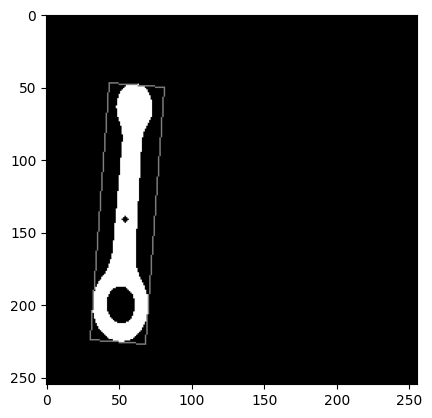

The rod labeled 1 in the image TESI01.BMP is of type A
Its barycenter is at position [119.11866502 201.3461063 ], it has an orientation angle of 113.20 degrees, its length is 168.47, its width is 39.92, and its width at the barycenter is 15.23
The only hole in the rod is at position (179.00265502929688, 68.69575500488281) and has diameter equal to 23.12


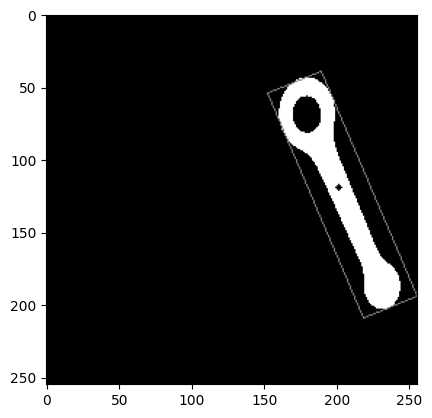

The rod labeled 2 in the image TESI01.BMP is of type B
Its barycenter is at position [114.33063428 115.16531714], it has an orientation angle of 83.50 degrees, its length is 131.86, its width is 27.17, and its width at the barycenter is 14.04
The first hole in the rod is at position (109.9406509399414, 158.95973205566406) and has diameter equal to 25.18
The second hole in the rod is at position (121.07308959960938, 60.35710525512695) and has diameter equal to 21.85


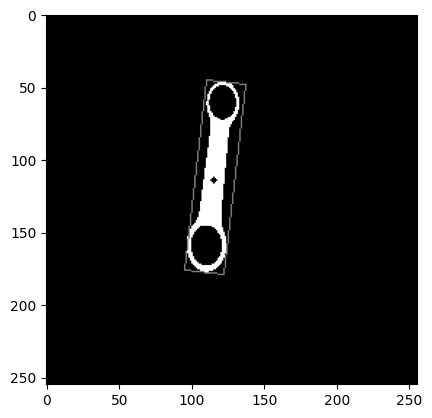

The rod labeled 3 in the image TESI01.BMP is of type A
Its barycenter is at position [141.29555896  54.80704441], it has an orientation angle of 85.99 degrees, its length is 177.48, its width is 38.12, and its width at the barycenter is 14.04
The only hole in the rod is at position (50.980316162109375, 199.88467407226562) and has diameter equal to 23.12


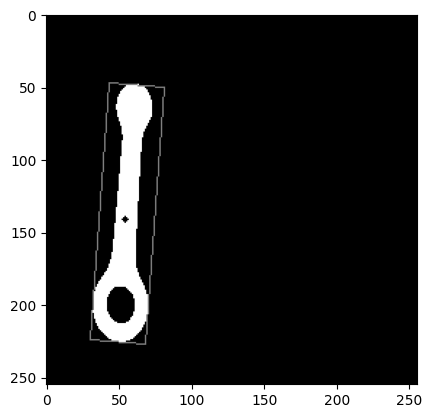

The rod labeled 1 in the image TESI12.BMP is of type A
Its barycenter is at position [82.11927452 82.30187519], it has an orientation angle of 42.02 degrees, its length is 152.23, its width is 44.60, and its width at the barycenter is 16.97
The only hole in the rod is at position (45.0641975402832, 115.52098083496094) and has diameter equal to 23.21


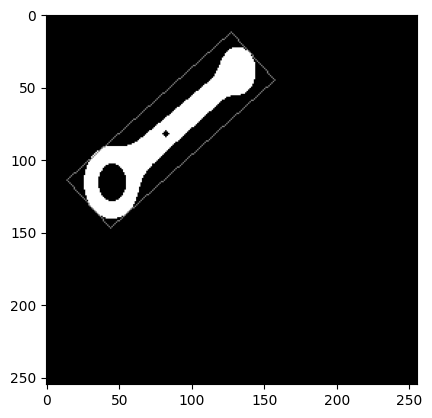

The rod labeled 2 in the image TESI12.BMP is of type B
Its barycenter is at position [116.59218643 128.66826594], it has an orientation angle of 3.43 degrees, its length is 101.18, its width is 35.06, and its width at the barycenter is 17.03
The first hole in the rod is at position (86.84964752197266, 119.11109924316406) and has diameter equal to 22.14
The second hole in the rod is at position (163.11500549316406, 114.72623443603516) and has diameter equal to 25.12


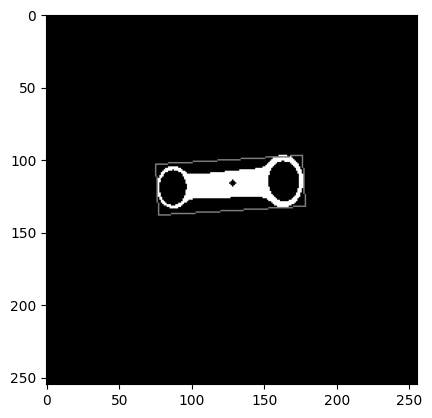

The rod labeled 3 in the image TESI12.BMP is of type A
Its barycenter is at position [172.2095679  104.61388889], it has an orientation angle of 5.36 degrees, its length is 136.62, its width is 49.25, and its width at the barycenter is 19.10
The only hole in the rod is at position (149.74118041992188, 167.6407928466797) and has diameter equal to 23.68


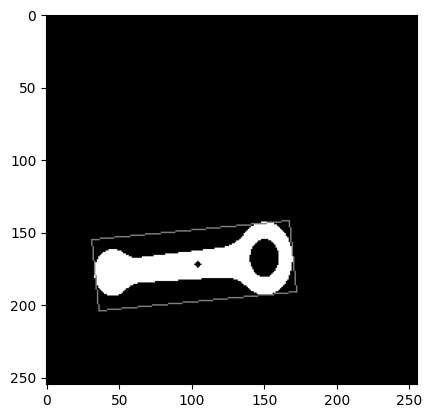

The rod labeled 1 in the image TESI21.BMP is of type B
Its barycenter is at position [ 92.11096829 113.89760069], it has an orientation angle of 63.54 degrees, its length is 155.18, its width is 36.67, and its width at the barycenter is 17.89
The first hole in the rod is at position (84.41535186767578, 149.54319763183594) and has diameter equal to 27.87
The second hole in the rod is at position (137.7353973388672, 44.457252502441406) and has diameter equal to 31.23


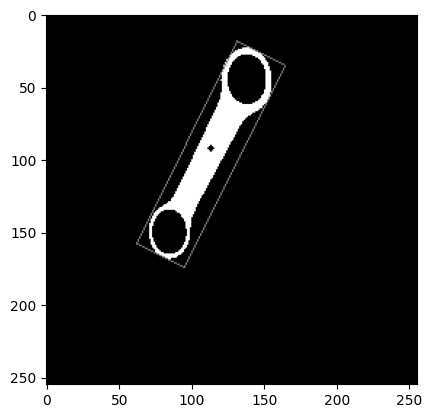

The rod labeled 2 in the image TESI21.BMP is of type A
Its barycenter is at position [162.29849595 153.34168916], it has an orientation angle of 42.18 degrees, its length is 192.59, its width is 56.64, and its width at the barycenter is 21.93
The only hole in the rod is at position (200.6361541748047, 119.82860565185547) and has diameter equal to 29.39


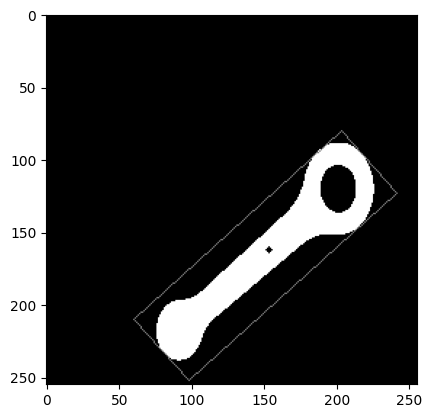

The rod labeled 1 in the image TESI31.BMP is of type A
Its barycenter is at position [142.9026801  189.45466641], it has an orientation angle of 59.57 degrees, its length is 208.03, its width is 51.97, and its width at the barycenter is 19.72
The only hole in the rod is at position (224.2989044189453, 83.80757904052734) and has diameter equal to 28.58


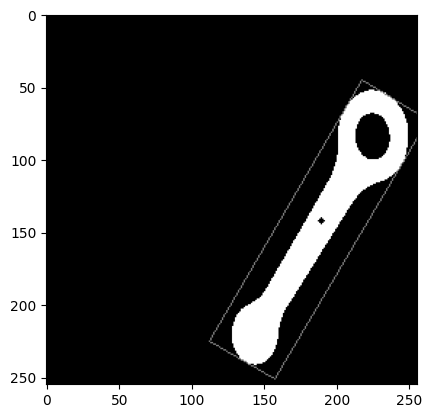

The rod labeled 2 in the image TESI31.BMP is of type B
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of 3.12 degrees, its length is 127.19, its width is 46.10, and its width at the barycenter is 23.02
The first hole in the rod is at position (33.2103157043457, 163.65582275390625) and has diameter equal to 27.03
The second hole in the rod is at position (129.3745880126953, 157.9435577392578) and has diameter equal to 31.41


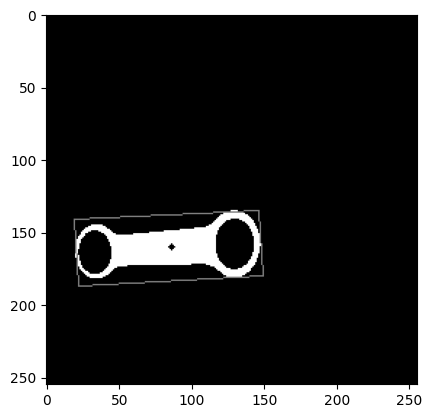

In [52]:
areas = []
rod_type_a_example = None
rod_type_b_example = None

for img_name in TASK_IMGLIST['TASK_1']:
    n_labels, label_ids, stats, centroids = CONNECTED_COMPONENTS[img_name]
    for label in range(1, n_labels):
        mask = getCCMask(label_ids, label)
        contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
        rod_barycenter = (getMoment(mask, (1,0)), getMoment(mask, (0,1))) / stats[label][-1]
        (theta, (a, b, c), (a_prime, b_prime, c_prime)) = getAngleAndAxes(mask, stats[label][-1])
        V1, V2, V3, V4, C1, C2, C3, C4 = findMER((a, b, c), (a_prime, b_prime, c_prime), contours[0])
        length = np.linalg.norm(V1 - V2)
        width = np.linalg.norm(V1 - V3)
        angle_deg = np.degrees(theta)
        barycenter_width, point_A, point_B = getWidthAtBarycenter(contours[0], (a_prime, b_prime, c_prime), (a,b,c))
        areas.append(stats[label][-1])
        
        rod_type = "A" if len(contours) == 2 else "B"
        print("The rod labeled %d in the image %s is of type %s" % (label, img_name, rod_type))
        print("Its barycenter is at position %s, it has an orientation angle of %.2f degrees, its length is %.2f, its width is %.2f, and its width at the barycenter is %.2f" \
              % (str(rod_barycenter), angle_deg, length, width, barycenter_width))
        if rod_type == "A":
            hole_center, hole_diameter = getHoleCenterAndDiameter(contours[1])
            print("The only hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center), hole_diameter))
            if rod_type_a_example is None:
                rod_type_a_example = copy.deepcopy(BINARIZED_IMAGES[img_name][stats[label][1] : stats[label][1] + stats[label][3], stats[label][0]:stats[label][0] + stats[label][2]])
        elif rod_type == "B":
            hole_center_1, hole_diameter_1 = getHoleCenterAndDiameter(contours[1])
            print("The first hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_1), hole_diameter_1))
            hole_center_2, hole_diameter_2 = getHoleCenterAndDiameter(contours[2])
            print("The second hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_2), hole_diameter_2))
            if rod_type_b_example is None:
                rod_type_b_example = copy.deepcopy(BINARIZED_IMAGES[img_name][stats[label][1] : stats[label][1] + stats[label][3], stats[label][0]:stats[label][0] + stats[label][2]])

            
        cv.circle(mask, (int(rod_barycenter[1]), int(rod_barycenter[0])), radius=2, color=(0, 0, 0), thickness=-1)
        cv.drawContours(mask, np.array([[V2, V4, V3, V1]]), contourIdx=0, color=(128,128,128), thickness=1)
        plt.imshow(mask, cmap="gray")
        plt.show()

areas = np.array(areas)
a, loc, scale = scipy.stats.gamma.fit(areas)
area_confidence_interval = scipy.stats.gamma.interval(0.95, a, loc, scale)

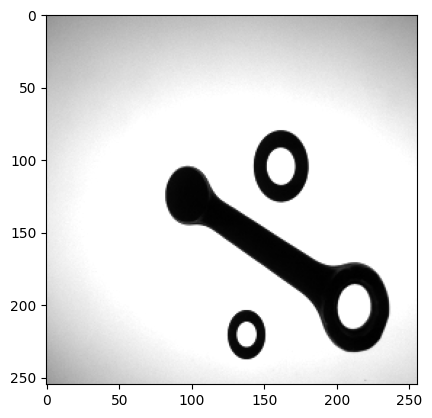

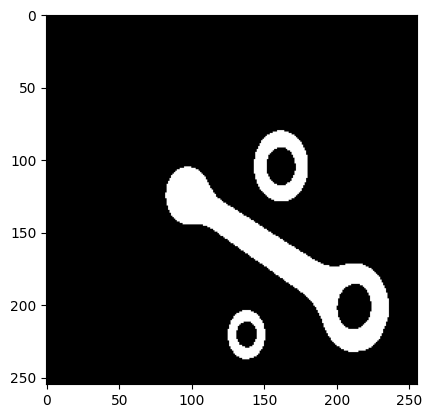

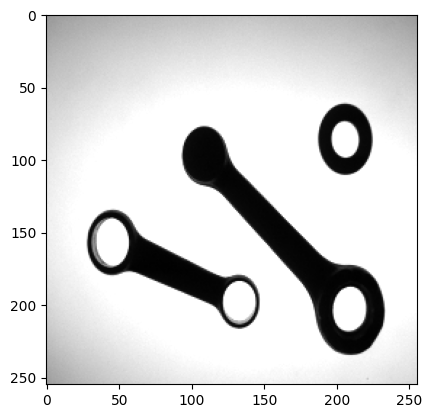

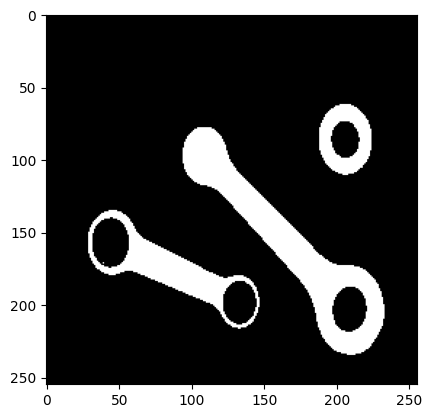

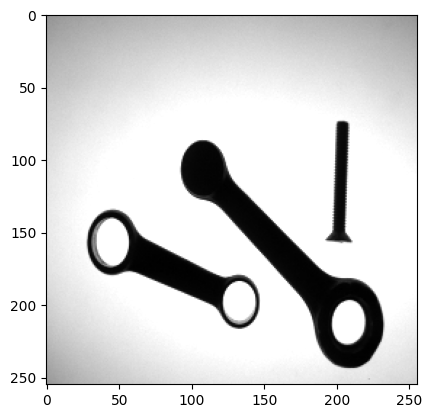

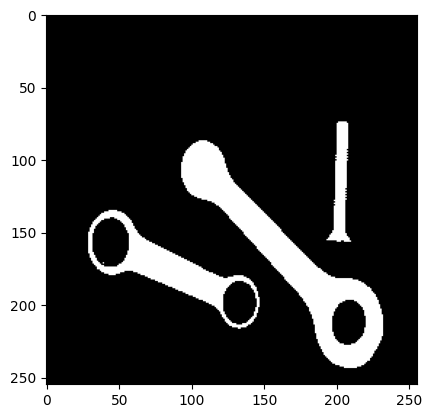

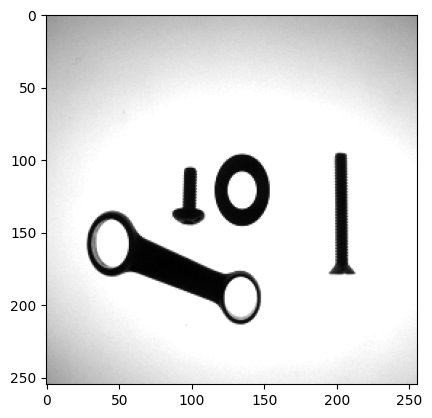

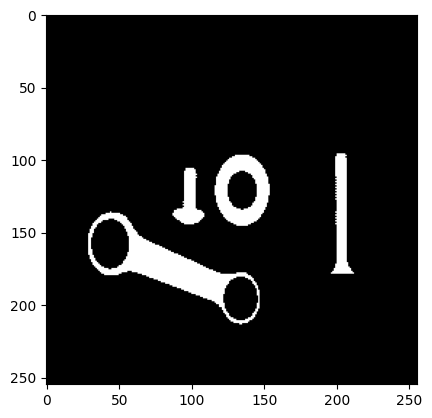

In [53]:
for img_name in TASK_IMGLIST['TASK_2_1']:
    threshold, binarized_img = binarizeImage(IMAGES[img_name], kde_bandwidth=6)
    BINARIZED_IMAGES[img_name] = binarized_img
    plt.imshow(IMAGES[img_name], cmap="gray")
    plt.show()
    plt.imshow(binarized_img, cmap="gray")
    plt.show()

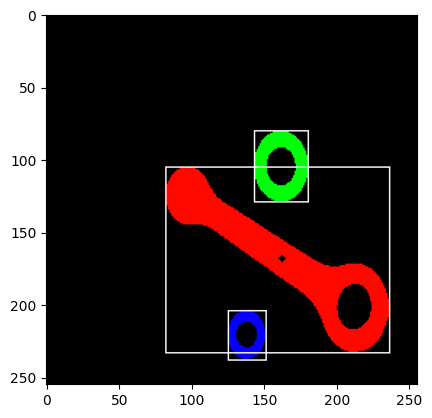

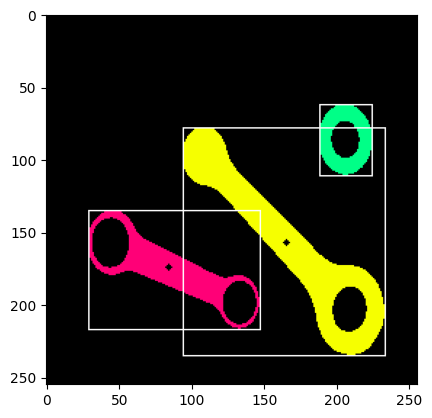

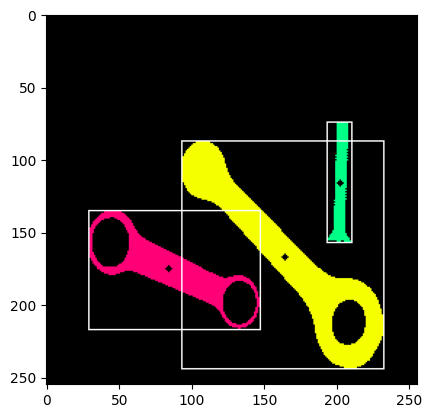

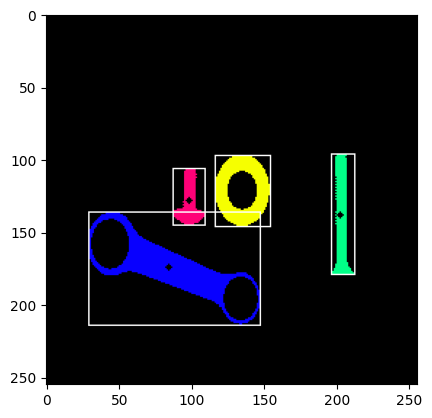

In [54]:
for img_name in TASK_IMGLIST['TASK_2_1']:
    n_labels, label_ids, stats, centroids = cv.connectedComponentsWithStats(BINARIZED_IMAGES[img_name], connectivity=4)
    CONNECTED_COMPONENTS[img_name] = (n_labels, label_ids, stats, centroids)
    plot_connected_components(n_labels, label_ids, stats, centroids)

The rod labeled 2 in the image TESI44.BMP is of type A
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of -34.58 degrees, its length is 180.57, its width is 56.86, and its width at the barycenter is 21.63
The only hole in the rod is at position (211.66403198242188, 201.11619567871094) and has diameter equal to 27.98


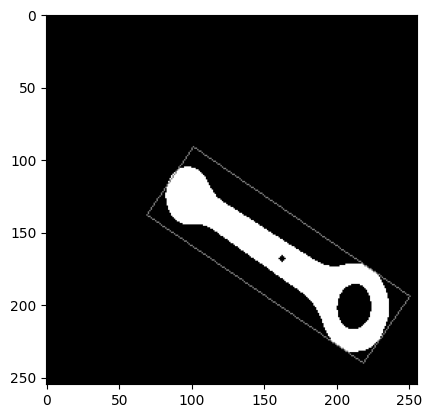

The rod labeled 2 in the image TESI47.BMP is of type A
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of 132.68 degrees, its length is 191.78, its width is 54.49, and its width at the barycenter is 21.21
The only hole in the rod is at position (208.4370880126953, 202.94590759277344) and has diameter equal to 27.98


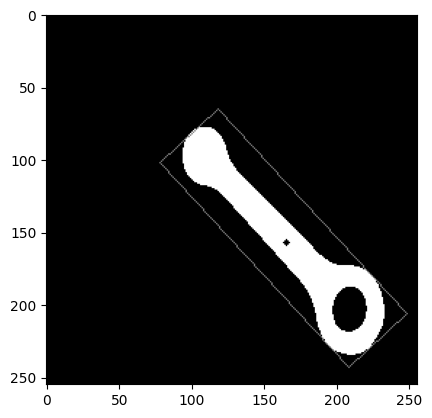

The rod labeled 3 in the image TESI47.BMP is of type B
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of -26.08 degrees, its length is 128.81, its width is 43.38, and its width at the barycenter is 21.02
The first hole in the rod is at position (132.7435302734375, 198.32180786132812) and has diameter equal to 27.16
The second hole in the rod is at position (43.91827392578125, 156.9834747314453) and has diameter equal to 30.55


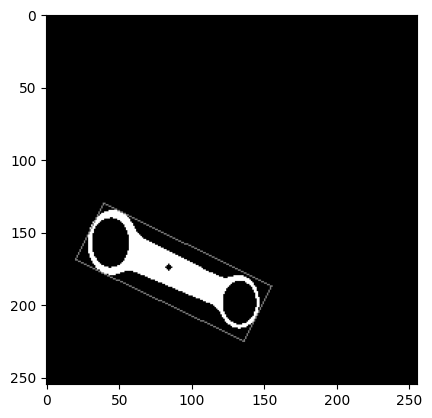

The rod labeled 2 in the image TESI48.BMP is of type A
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of 132.82 degrees, its length is 191.05, its width is 53.76, and its width at the barycenter is 20.52
The only hole in the rod is at position (207.8555145263672, 212.04380798339844) and has diameter equal to 27.85


/tmp/ipykernel_28946/1206955847.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  return mu_r / sigma_r


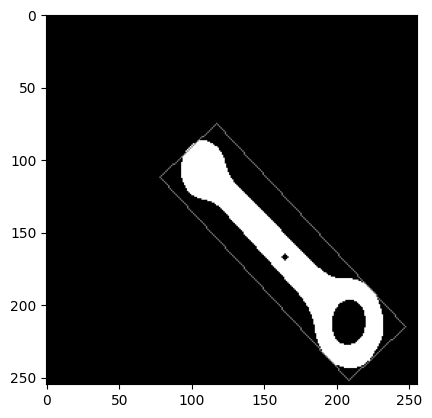

The rod labeled 3 in the image TESI48.BMP is of type B
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of -26.07 degrees, its length is 128.81, its width is 43.38, and its width at the barycenter is 21.02
The first hole in the rod is at position (132.7198486328125, 198.38937377929688) and has diameter equal to 27.14
The second hole in the rod is at position (43.94982147216797, 156.86387634277344) and has diameter equal to 30.51


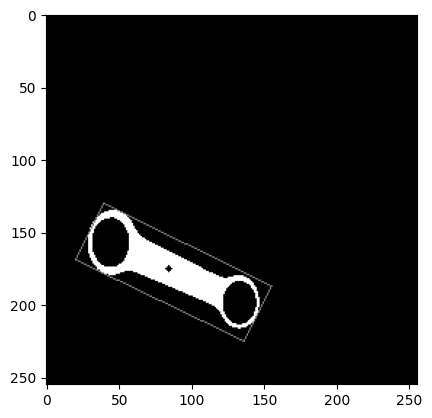

The rod labeled 4 in the image TESI49.BMP is of type B
Its barycenter is at position [160.18032112  86.20008234], it has an orientation angle of -23.94 degrees, its length is 128.04, its width is 42.54, and its width at the barycenter is 21.02
The first hole in the rod is at position (133.47796630859375, 195.50531005859375) and has diameter equal to 27.59
The second hole in the rod is at position (43.65092849731445, 157.833251953125) and has diameter equal to 30.87


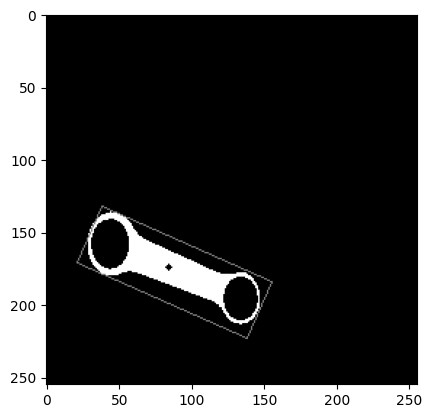

In [55]:
for img_name in TASK_IMGLIST['TASK_2_1']:
    n_labels, label_ids, stats, centroids = CONNECTED_COMPONENTS[img_name]
    for label in range(1, n_labels):
        mask = getCCMask(label_ids, label)
        contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
        barycenter = (getMoment(mask, (1,0)), getMoment(mask, (0,1))) / stats[label][-1]
        hc = computeHaralickCircularity(contours[0], rod_barycenter)
        hu = cv.HuMoments(cv.moments(mask)).flatten()
        is_distractor = stats[label][-1] < area_confidence_interval[0] or stats[label][-1] > area_confidence_interval[1]
            
        if not is_distractor:
            (theta, (a, b, c), (a_prime, b_prime, c_prime)) = getAngleAndAxes(mask, stats[label][-1])
            V1, V2, V3, V4, C1, C2, C3, C4 = findMER((a, b, c), (a_prime, b_prime, c_prime), contours[0])
            length = np.linalg.norm(V1 - V2)
            width = np.linalg.norm(V1 - V3)
            angle_deg = np.degrees(theta)
            barycenter_width, point_A, point_B = getWidthAtBarycenter(contours[0], (a_prime, b_prime, c_prime), (a,b,c))
            
            rod_type = "A" if len(contours) == 2 else "B"
            print("The rod labeled %d in the image %s is of type %s" % (label, img_name, rod_type))
            print("Its barycenter is at position %s, it has an orientation angle of %.2f degrees, its length is %.2f, its width is %.2f, and its width at the barycenter is %.2f" \
                  % (str(rod_barycenter), angle_deg, length, width, barycenter_width))
            if rod_type == "A":
                hole_center, hole_diameter = getHoleCenterAndDiameter(contours[1])
                print("The only hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center), hole_diameter))
            elif rod_type == "B":
                hole_center_1, hole_diameter_1 = getHoleCenterAndDiameter(contours[1])
                print("The first hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_1), hole_diameter_1))
                hole_center_2, hole_diameter_2 = getHoleCenterAndDiameter(contours[2])
                print("The second hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_2), hole_diameter_2))

            cv.circle(mask, (int(barycenter[1]), int(barycenter[0])), radius=2, color=(0, 0, 0), thickness=-1)
            cv.drawContours(mask, np.array([[V2, V4, V3, V1]]), contourIdx=0, color=(128,128,128), thickness=1)
            plt.imshow(mask, cmap="gray")
            plt.show()

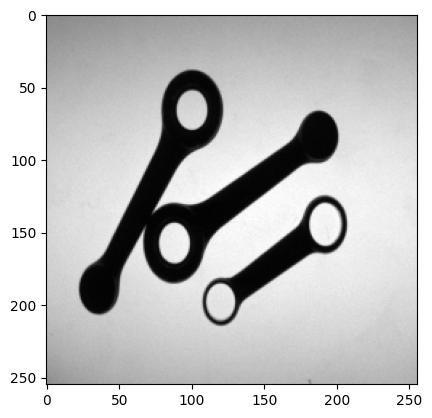

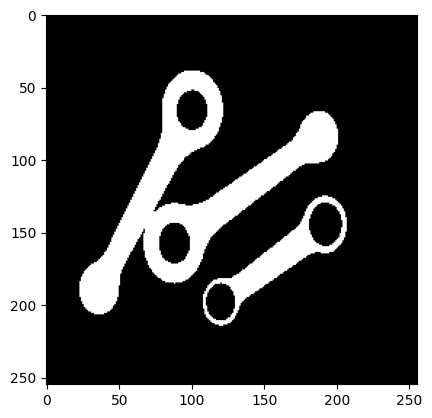

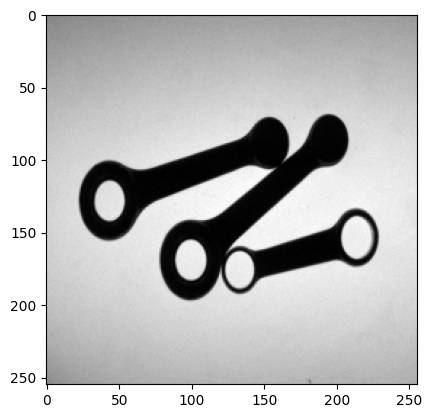

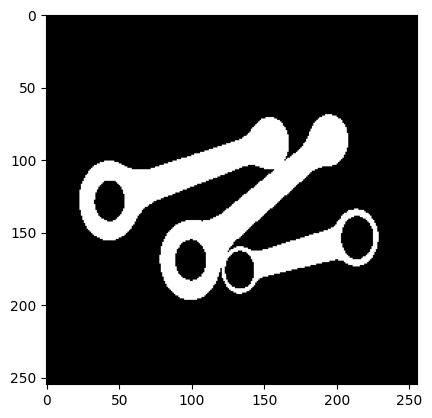

In [56]:
for img_name in TASK_IMGLIST['TASK_2_2']:
    threshold, binarized_img = binarizeImage(IMAGES[img_name], kde_bandwidth=6)
    BINARIZED_IMAGES[img_name] = binarized_img
    plt.imshow(IMAGES[img_name], cmap="gray")
    plt.show()
    plt.imshow(binarized_img, cmap="gray")
    plt.show()

The box number 1 contains two or more objects
[ 71.375      142.34722222]


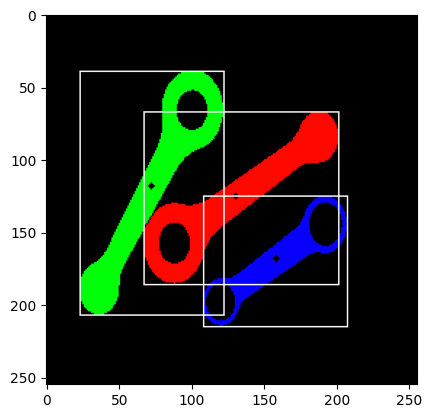

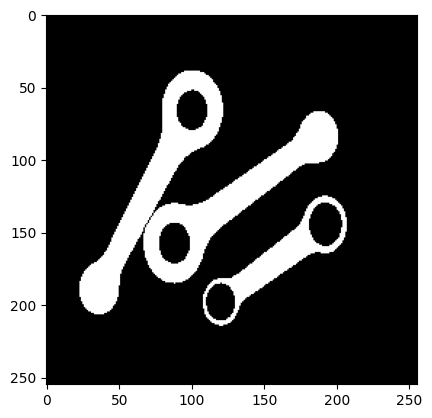

The box number 1 contains two or more objects
[160.625      103.41071429]
[123.89090909 169.58181818]


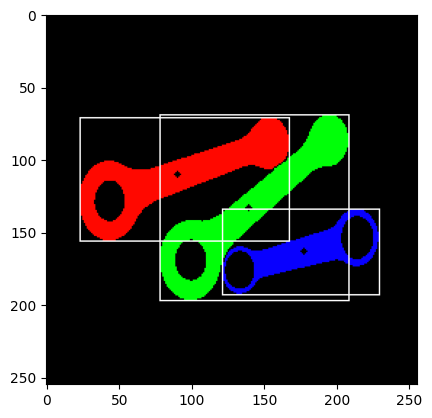

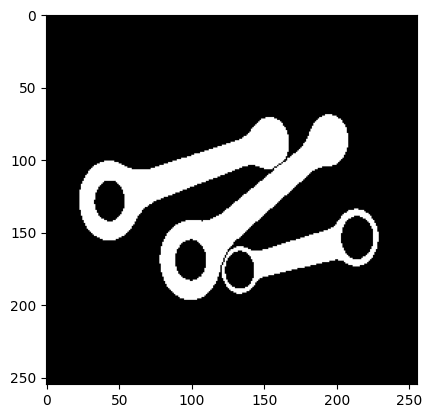

In [57]:
from sklearn.cluster import DBSCAN
for img_name in TASK_IMGLIST['TASK_2_2']:
    img = IMAGES[img_name]
    bin_img = BINARIZED_IMAGES[img_name]
    n_labels, label_ids, stats, centroids = cv.connectedComponentsWithStats(BINARIZED_IMAGES[img_name], connectivity=4)

    for i, stat in enumerate(stats[1:]):
        if stat[-1] > 5300:
            mask = getCCMask(label_ids, i+1)
            print("The box number %d contains two or more objects" % (i+1))
            contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            contour = contours[0]
            hull = cv.convexHull(contour, returnPoints=False)
            defects = cv.convexityDefects(contour, hull)
            points = []
            for i in range(defects.shape[0]):
                _, _, index, _ = defects[i, 0]
                point = tuple(contour[index][0])
                points.append(point)
                
            points = np.array(points)
            
            gray = np.float32(img)
            dst = cv.cornerHarris(gray,2,3,0.04)
            dst = cv.dilate(dst,None)
            y, x = np.where(dst > 0.05 * dst.max())
            harris_corner_points = np.zeros((len(x), 2))
            harris_corner_points[:,0] = x
            harris_corner_points[:,1] = y

            clustering = DBSCAN(eps=20, min_samples=2).fit(harris_corner_points)
            for label in np.unique(clustering.labels_):
                cluster_points = harris_corner_points[clustering.labels_ == label]
                center = np.mean(cluster_points, axis=0)
                print(center)
                hull_defects_distances = np.linalg.norm(np.array(points) - center, axis=1)
                p1_i, p2_i = tuple(np.argsort(hull_defects_distances)[:2])
                p1 = points[p1_i]
                p2 = points[p2_i]
                bin_img = cv.line(bin_img, p1, p2, 0)
    
    n_labels, label_ids, stats, centroids = cv.connectedComponentsWithStats(bin_img, connectivity=4)
    CONNECTED_COMPONENTS[img_name] = (n_labels, label_ids, stats, centroids)
    plot_connected_components(n_labels, label_ids, stats, centroids)
    
    plt.imshow(bin_img, cmap="gray")
    plt.show()

The rod labeled 1 in the image TESI50.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 62.80 degrees, its length is 182.02, its width is 45.18, and its width at the barycenter is 16.55
The only hole in the rod is at position (99.99056243896484, 65.75396728515625) and has diameter equal to 25.08


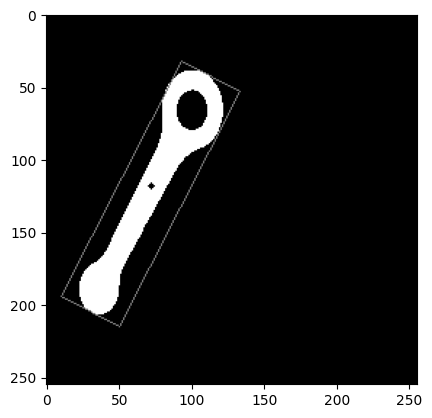

The rod labeled 2 in the image TESI50.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 36.91 degrees, its length is 161.40, its width is 50.61, and its width at the barycenter is 19.42
The only hole in the rod is at position (87.9353256225586, 157.39930725097656) and has diameter equal to 25.53


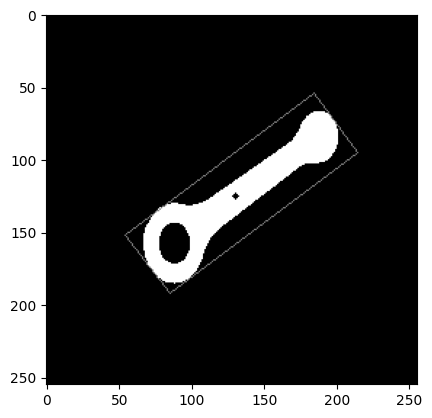

The rod labeled 3 in the image TESI50.BMP is of type B
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 37.79 degrees, its length is 120.42, its width is 36.40, and its width at the barycenter is 17.80
The first hole in the rod is at position (119.66697692871094, 197.905517578125) and has diameter equal to 23.64
The second hole in the rod is at position (191.85800170898438, 144.3861846923828) and has diameter equal to 26.93


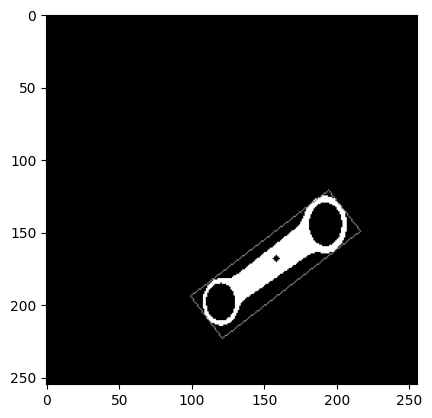

The rod labeled 1 in the image TESI51.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 41.50 degrees, its length is 165.76, its width is 49.58, and its width at the barycenter is 19.21
The only hole in the rod is at position (99.111083984375, 169.0671844482422) and has diameter equal to 25.42


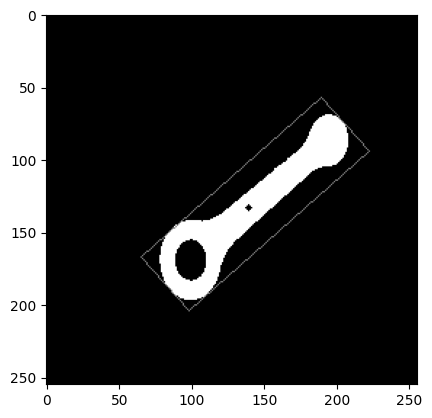

The rod labeled 2 in the image TESI51.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 20.21 degrees, its length is 152.51, its width is 53.49, and its width at the barycenter is 20.25
The only hole in the rod is at position (43.32304000854492, 128.25279235839844) and has diameter equal to 24.96


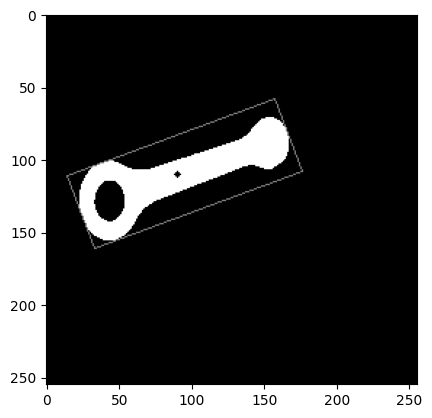

The rod labeled 3 in the image TESI51.BMP is of type B
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 16.52 degrees, its length is 111.68, its width is 38.60, and its width at the barycenter is 18.97
The first hole in the rod is at position (132.78538513183594, 175.8479766845703) and has diameter equal to 23.83
The second hole in the rod is at position (213.66709899902344, 153.58787536621094) and has diameter equal to 26.58


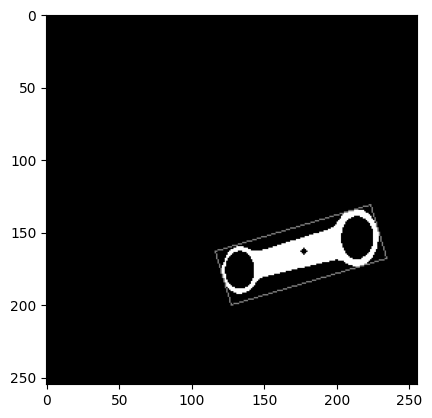

In [59]:
for img_name in TASK_IMGLIST['TASK_2_2']:
    n_labels, label_ids, stats, centroids = CONNECTED_COMPONENTS[img_name]
    for label in range(1, n_labels):
        mask = getCCMask(label_ids, label)
        contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
        barycenter = (getMoment(mask, (1,0)), getMoment(mask, (0,1))) / stats[label][-1]
        hc = computeHaralickCircularity(contours[0], rod_barycenter)
        hu = cv.HuMoments(cv.moments(mask)).flatten()
        is_distractor = stats[label][-1] < area_confidence_interval[0] or stats[label][-1] > area_confidence_interval[1]
            
        if not is_distractor:
            (theta, (a, b, c), (a_prime, b_prime, c_prime)) = getAngleAndAxes(mask, stats[label][-1])
            V1, V2, V3, V4, C1, C2, C3, C4 = findMER((a, b, c), (a_prime, b_prime, c_prime), contours[0])
            length = np.linalg.norm(V1 - V2)
            width = np.linalg.norm(V1 - V3)
            angle_deg = np.degrees(theta)
            barycenter_width, point_A, point_B = getWidthAtBarycenter(contours[0], (a_prime, b_prime, c_prime), (a,b,c))
            
            rod_type = "A" if len(contours) == 2 else "B"
            print("The rod labeled %d in the image %s is of type %s" % (label, img_name, rod_type))
            print("Its barycenter is at position %s, it has an orientation angle of %.2f degrees, its length is %.2f, its width is %.2f, and its width at the barycenter is %.2f" \
                  % (str(rod_barycenter), angle_deg, length, width, barycenter_width))
            if rod_type == "A":
                hole_center, hole_diameter = getHoleCenterAndDiameter(contours[1])
                print("The only hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center), hole_diameter))
            elif rod_type == "B":
                hole_center_1, hole_diameter_1 = getHoleCenterAndDiameter(contours[1])
                print("The first hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_1), hole_diameter_1))
                hole_center_2, hole_diameter_2 = getHoleCenterAndDiameter(contours[2])
                print("The second hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_2), hole_diameter_2))

            cv.circle(mask, (int(barycenter[1]), int(barycenter[0])), radius=2, color=(0, 0, 0), thickness=-1)
            cv.drawContours(mask, np.array([[V2, V4, V3, V1]]), contourIdx=0, color=(128,128,128), thickness=1)
            plt.imshow(mask, cmap="gray")
            plt.show()

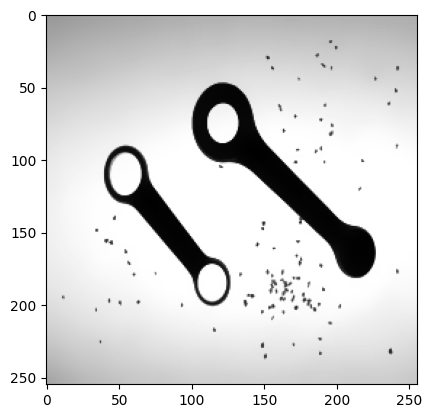

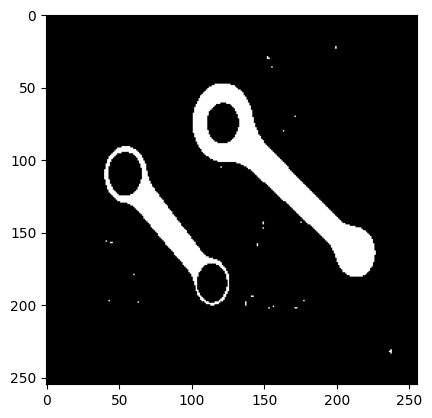

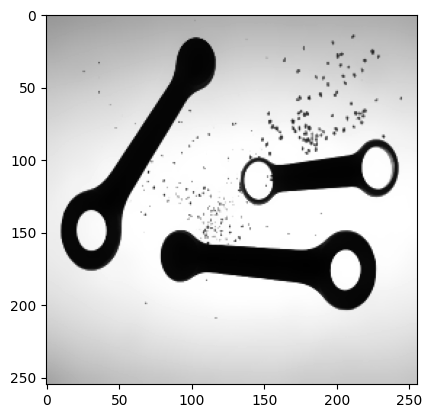

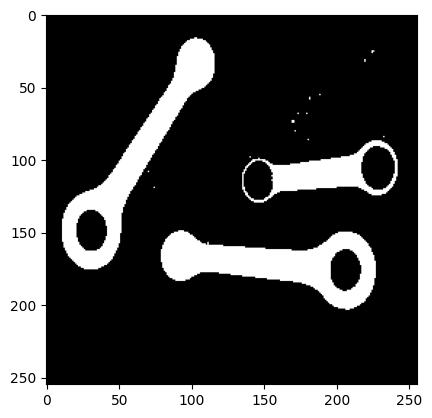

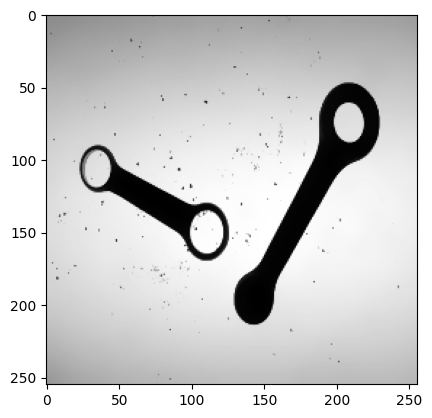

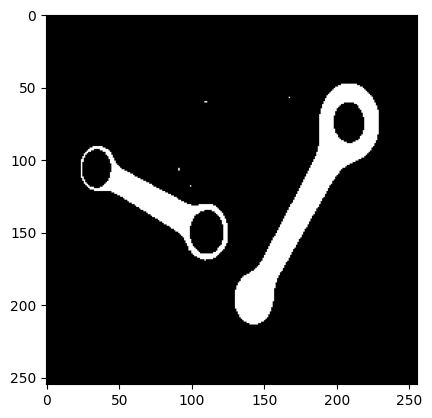

In [60]:
for img_name in TASK_IMGLIST['TASK_2_3']:
    img = copy.deepcopy(IMAGES[img_name])
    img = cv.bilateralFilter(img, d=17, sigmaColor=24, sigmaSpace=12)
    threshold, binarized_img = binarizeImage(img, kde_bandwidth=6)
    BINARIZED_IMAGES[img_name] = binarized_img
    plt.imshow(img, cmap="gray")
    plt.show()
    plt.imshow(binarized_img, cmap="gray")
    plt.show()

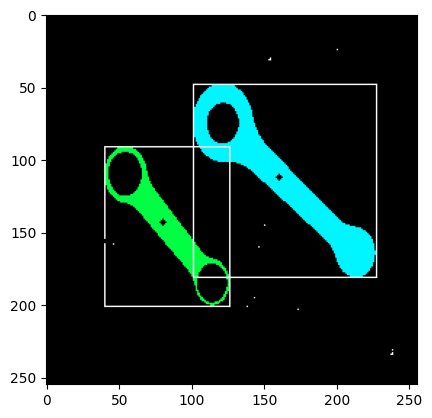

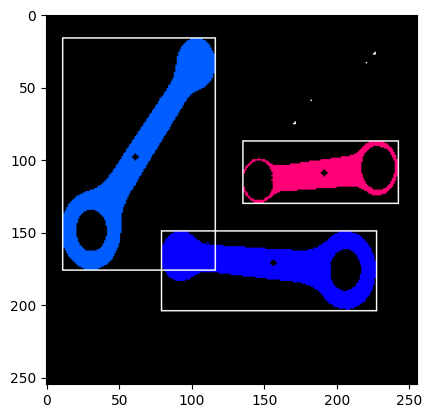

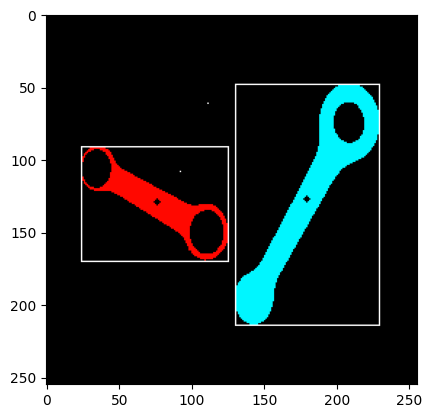

In [61]:
for img_name in TASK_IMGLIST['TASK_2_3']:
    n_labels, label_ids, stats, centroids = cv.connectedComponentsWithStats(BINARIZED_IMAGES[img_name], connectivity=4)
    CONNECTED_COMPONENTS[img_name] = (n_labels, label_ids, stats, centroids)
    plot_connected_components(n_labels, label_ids, stats, centroids)

/tmp/ipykernel_28946/1206955847.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  return mu_r / sigma_r


The rod labeled 4 in the image TESI90.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of -44.96 degrees, its length is 166.88, its width is 48.08, and its width at the barycenter is 17.69
The only hole in the rod is at position (121.24382019042969, 74.66915130615234) and has diameter equal to 25.74


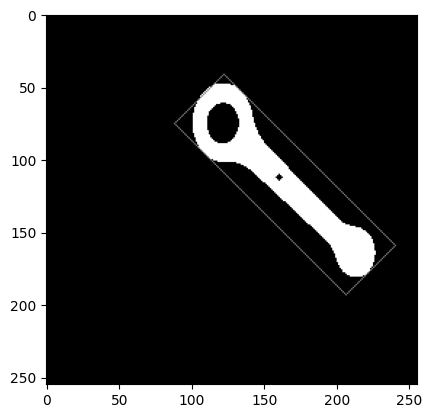

The rod labeled 7 in the image TESI90.BMP is of type B
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 127.98 degrees, its length is 126.82, its width is 32.80, and its width at the barycenter is 16.40
The first hole in the rod is at position (113.80111694335938, 184.8180694580078) and has diameter equal to 24.48
The second hole in the rod is at position (53.93988037109375, 109.53501892089844) and has diameter equal to 27.32


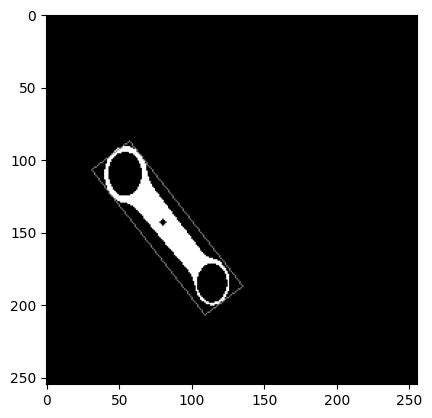

The rod labeled 1 in the image TESI92.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 58.32 degrees, its length is 177.34, its width is 44.42, and its width at the barycenter is 16.64
The only hole in the rod is at position (30.82427406311035, 148.6352081298828) and has diameter equal to 25.47


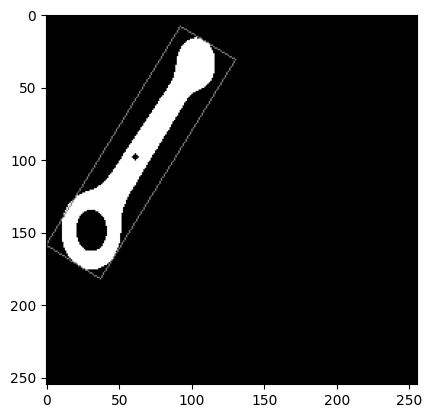

The rod labeled 12 in the image TESI92.BMP is of type B
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 6.93 degrees, its length is 107.79, its width is 37.22, and its width at the barycenter is 19.10
The first hole in the rod is at position (145.6640625, 114.24248504638672) and has diameter equal to 24.41
The second hole in the rod is at position (227.98208618164062, 105.50941467285156) and has diameter equal to 27.25


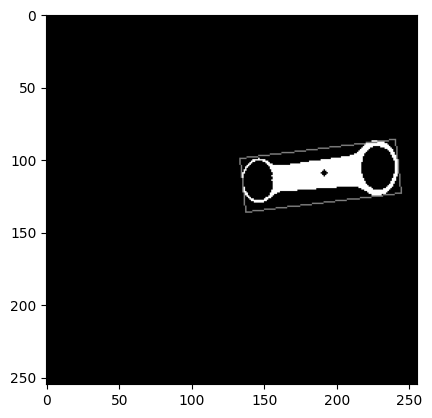

The rod labeled 16 in the image TESI92.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of -5.18 degrees, its length is 147.57, its width is 53.24, and its width at the barycenter is 20.10
The only hole in the rod is at position (205.64859008789062, 175.8867645263672) and has diameter equal to 25.53


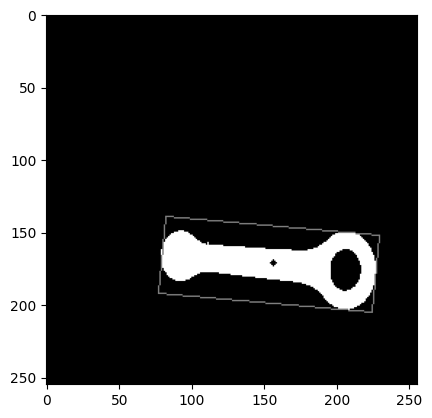

The rod labeled 1 in the image TESI98.BMP is of type A
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of 61.96 degrees, its length is 179.82, its width is 44.29, and its width at the barycenter is 16.12
The only hole in the rod is at position (208.0237274169922, 74.27300262451172) and has diameter equal to 25.29


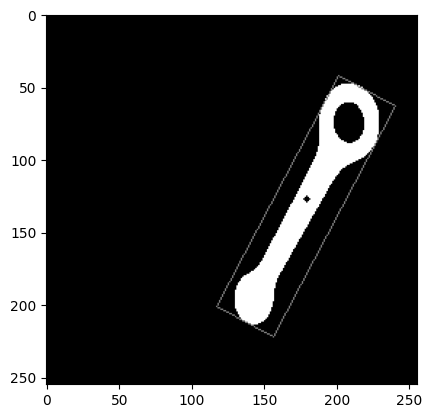

The rod labeled 4 in the image TESI98.BMP is of type B
Its barycenter is at position [163.62248322 177.16946309], it has an orientation angle of -31.62 degrees, its length is 116.28, its width is 36.36, and its width at the barycenter is 18.36
The first hole in the rod is at position (110.13391876220703, 149.76451110839844) and has diameter equal to 27.54
The second hole in the rod is at position (34.29117202758789, 106.00048828125) and has diameter equal to 24.03


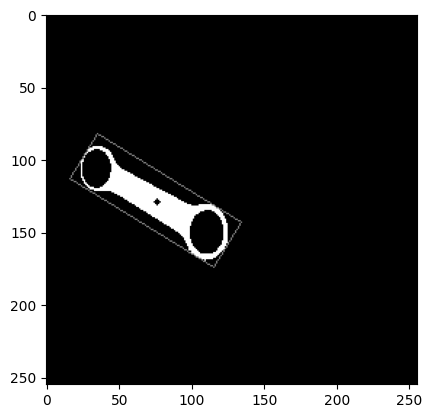

In [62]:
for img_name in TASK_IMGLIST['TASK_2_3']:
    n_labels, label_ids, stats, centroids = CONNECTED_COMPONENTS[img_name]
    for label in range(1, n_labels):
        mask = getCCMask(label_ids, label)
        contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
        barycenter = (getMoment(mask, (1,0)), getMoment(mask, (0,1))) / stats[label][-1]
        hc = computeHaralickCircularity(contours[0], rod_barycenter)
        hu = cv.HuMoments(cv.moments(mask)).flatten()
        is_distractor = stats[label][-1] < area_confidence_interval[0] or stats[label][-1] > area_confidence_interval[1]
            
        if not is_distractor:
            (theta, (a, b, c), (a_prime, b_prime, c_prime)) = getAngleAndAxes(mask, stats[label][-1])
            V1, V2, V3, V4, C1, C2, C3, C4 = findMER((a, b, c), (a_prime, b_prime, c_prime), contours[0])
            length = np.linalg.norm(V1 - V2)
            width = np.linalg.norm(V1 - V3)
            angle_deg = np.degrees(theta)
            barycenter_width, point_A, point_B = getWidthAtBarycenter(contours[0], (a_prime, b_prime, c_prime), (a,b,c))
            
            rod_type = "A" if len(contours) == 2 else "B"
            print("The rod labeled %d in the image %s is of type %s" % (label, img_name, rod_type))
            print("Its barycenter is at position %s, it has an orientation angle of %.2f degrees, its length is %.2f, its width is %.2f, and its width at the barycenter is %.2f" \
                  % (str(rod_barycenter), angle_deg, length, width, barycenter_width))
            if rod_type == "A":
                hole_center, hole_diameter = getHoleCenterAndDiameter(contours[1])
                print("The only hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center), hole_diameter))
            elif rod_type == "B":
                hole_center_1, hole_diameter_1 = getHoleCenterAndDiameter(contours[1])
                print("The first hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_1), hole_diameter_1))
                hole_center_2, hole_diameter_2 = getHoleCenterAndDiameter(contours[2])
                print("The second hole in the rod is at position %s and has diameter equal to %.2f" % (str(hole_center_2), hole_diameter_2))

            cv.circle(mask, (int(barycenter[1]), int(barycenter[0])), radius=2, color=(0, 0, 0), thickness=-1)
            cv.drawContours(mask, np.array([[V2, V4, V3, V1]]), contourIdx=0, color=(128,128,128), thickness=1)
            plt.imshow(mask, cmap="gray")
            plt.show()